In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import sys
from collections import OrderedDict
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from typing import Union, Tuple
from torch.utils.data import Dataset, DataLoader
import cv2

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

In [12]:
train_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())

In [13]:
train_loader = DataLoader(train_data, batch_size=len(train_data))
batch = next(iter(train_loader))
x, y = batch
mean, std = torch.mean(x), torch.std(x)
mean, std

(tensor(0.1307), tensor(0.3081))

In [14]:
transform  = transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean, std)
])

train_data = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

In [15]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Exercise 1
Implement an Autoencoder that encodes the MNIST dataset to a latent dimension of size
m < 784. Use Tranposed Convolutions and/or Unpooling to solve this exercise. Train the
Autoencoder and plot the reconstruction training loss. Plot 5 digits (of your choice) before
and after reconstruction. Do this for two different latent dimension sizes.

In [16]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(OrderedDict([
                                   ('conv1', nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1)),        #64* 14*14
                                   ('relu1', nn.LeakyReLU()),
                                   ('pool1', nn.MaxPool2d(2,2)),                                                                    #64*7*7
                                   ('conv2', nn.Conv2d(in_channels = 64,out_channels = 16,kernel_size = 3,stride = 2, padding=1)),  #16*4*4
                                   ('relu2', nn.LeakyReLU()),
                                   ('pool2', nn.MaxPool2d(2,1)),                                                                    #16*3*3
                                   ('conv3', nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, stride = 1, padding =1)),
                                   ('relu3', nn.LeakyReLU())])) 

    self.decoder = nn.Sequential(OrderedDict([
                                   ('convT1', nn.ConvTranspose2d(in_channels=16, out_channels=64, kernel_size=3, stride=2, padding=1)), #64* 5*5
                                   ('relu1', nn.LeakyReLU()),                                                            
                                   ('convT2', nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=4, stride=3, padding=1)),  #16*14*14
                                   ('relu2', nn.LeakyReLU()),
                                   ('convT3', nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=2, stride=2)),              #1*28*28
                                   ('tanh', nn.Tanh())]))   
    

  def forward(self, x):
    x1 = self.encoder(x)
    x2 = self.decoder(x1)
    return x2

In [17]:
model = Autoencoder().cuda()

In [18]:
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

In [19]:
def train(model: nn.Module,  optimizer: optim.Optimizer,  data: train_loader, max_epochs: int, cuda=True):
  total_loss = []
  for epoch in range(max_epochs):
      for batch in data:
          img, _ = batch
          img = Variable(img).cuda()
          # ===================forward=====================
          output = model(img)
          loss = criterion(output, img)
          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      # ===================log========================
      total_loss.append(loss.item())
      print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, max_epochs, loss.item()))
  return total_loss

  

In [20]:
model_losses = train(model, optimizer, train_loader, max_epochs=30)

epoch [1/30], loss:0.3837
epoch [2/30], loss:0.4051
epoch [3/30], loss:0.3983
epoch [4/30], loss:0.3678
epoch [5/30], loss:0.3928
epoch [6/30], loss:0.3539
epoch [7/30], loss:0.3494
epoch [8/30], loss:0.3258
epoch [9/30], loss:0.3786
epoch [10/30], loss:0.3493
epoch [11/30], loss:0.2783
epoch [12/30], loss:0.3571
epoch [13/30], loss:0.3716
epoch [14/30], loss:0.3445
epoch [15/30], loss:0.3438
epoch [16/30], loss:0.3499
epoch [17/30], loss:0.3412
epoch [18/30], loss:0.3336
epoch [19/30], loss:0.3920
epoch [20/30], loss:0.3491
epoch [21/30], loss:0.3336
epoch [22/30], loss:0.3285
epoch [23/30], loss:0.3638
epoch [24/30], loss:0.3422
epoch [25/30], loss:0.3752
epoch [26/30], loss:0.3460
epoch [27/30], loss:0.3623
epoch [28/30], loss:0.3198
epoch [29/30], loss:0.3369
epoch [30/30], loss:0.3363


In [21]:
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.cuda()
        reconstruction = model(test_examples)
        break

Plot digits before and after reconstruction

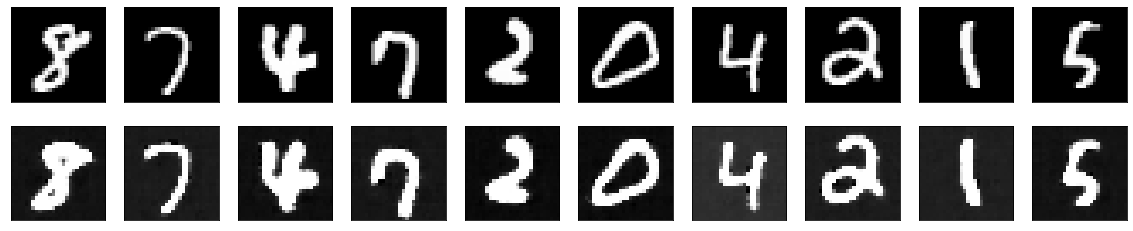

In [22]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples.cpu()[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction.cpu()[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

PLot the loss

Text(0.5, 1.0, 'MSE loss with our autoencoder')

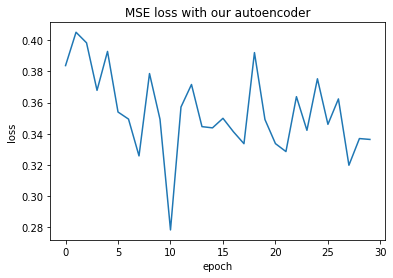

In [23]:
plt.plot(model_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('MSE loss with our autoencoder')

Another autoencoder architecture with different dimensions of latent state

In [24]:
class Autoencoder2(nn.Module):
  def __init__(self):
    super(Autoencoder2, self).__init__()
    self.encoder = nn.Sequential(OrderedDict([
                                   ('conv1', nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1)),        
                                   ('relu1', nn.LeakyReLU()),
                                   ('pool1', nn.MaxPool2d(2,2)),                                                                    
                                   ('conv2', nn.Conv2d(in_channels = 64,out_channels = 8,kernel_size = 3,stride = 3, padding=1)),  
                                   ('relu2', nn.LeakyReLU())]))
    self.pooling = nn.MaxPool2d(2,1, return_indices=True)
    self.convT = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1)
    self.unpooling = nn.MaxUnpool2d(2,2)

    self.decoder = nn.Sequential(OrderedDict([
                                   ('convT2', nn.ConvTranspose2d(in_channels=8, out_channels=64, kernel_size=5, stride=3, padding=1)),
                                   ('relu2', nn.LeakyReLU()),
                                   ('convT3', nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding = 1)),
                                   ('relu3', nn.LeakyReLU()),
                                   ('convT4', nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=5, stride=1, padding = 0)),
                                   ('tanh', nn.Tanh())]))   
    

  def forward(self, x):
    x1 = self.encoder(x)
    x1_pooled, indicies = self.pooling(x1)
    #x2 = self.convT(x1_pooled)
    #x2_unpooled = self.unpooling(x2,indicies)
    x2_unpooled = self.unpooling(x1_pooled,indicies)
    reconstructed = self.decoder(x2_unpooled)
    return reconstructed

In [25]:
model2 = Autoencoder2().cuda()
optimizer = optim.Adam(model2.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [26]:
model_losses2 = train(model2, optimizer, train_loader, max_epochs=30)

epoch [1/30], loss:0.5896
epoch [2/30], loss:0.6077
epoch [3/30], loss:0.5754
epoch [4/30], loss:0.5181
epoch [5/30], loss:0.5957
epoch [6/30], loss:0.5383
epoch [7/30], loss:0.6092
epoch [8/30], loss:0.5628
epoch [9/30], loss:0.5853
epoch [10/30], loss:0.5039
epoch [11/30], loss:0.5546
epoch [12/30], loss:0.5625
epoch [13/30], loss:0.5650
epoch [14/30], loss:0.5577
epoch [15/30], loss:0.5650
epoch [16/30], loss:0.5795
epoch [17/30], loss:0.5416
epoch [18/30], loss:0.5339
epoch [19/30], loss:0.5048
epoch [20/30], loss:0.5454
epoch [21/30], loss:0.5844
epoch [22/30], loss:0.5559
epoch [23/30], loss:0.6028
epoch [24/30], loss:0.5733
epoch [25/30], loss:0.5410
epoch [26/30], loss:0.5341
epoch [27/30], loss:0.5317
epoch [28/30], loss:0.5807
epoch [29/30], loss:0.5339
epoch [30/30], loss:0.5677


In [27]:
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.cuda()
        reconstruction = model2(test_examples)
        break

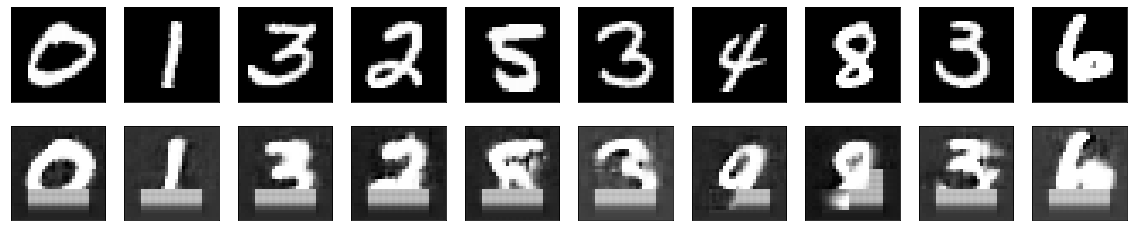

In [28]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples.cpu()[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction.cpu()[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Text(0.5, 1.0, 'MSE loss with our autoencoder')

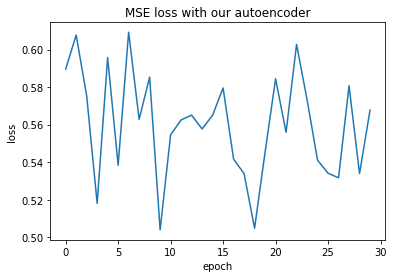

In [29]:
plt.plot(model_losses2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('MSE loss with our autoencoder')

## Exercise 2
Now that you have built an Autoencoder, it is time to implement a Variational Autoencoder.
You can use the Autoencoder you trained in the previous exercise and adapt it for this
exercise. Do not forget to use the reparametrization trick for sampling from Z-space.

In [30]:

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
class Unflatten(nn.Module):
    def __init__(self, channel, height, width):
        super(Unflatten, self).__init__()
        self.channel = channel
        self.height = height
        self.width = width

    def forward(self, input):
        return input.view(input.size(0), self.channel, self.height, self.width)


class ConvVAE(nn.Module):

    def __init__(self, latent_size):
        super(ConvVAE, self).__init__()

        self.latent_size = latent_size
        #encoder
        self.encoder = nn.Sequential(
            OrderedDict([
            ('conv1',nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)),
            ('relu1',nn.ReLU()),
            ('conv2',nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)),
            ('relu2',nn.ReLU()),
            ('flatten',Flatten()), #flatten 
            ('fc1',nn.Linear(6272, 1024)),
            ('relu3',nn.ReLU())
            ])) 
        #latent space 
        # hidden => mu
        self.fc1 = nn.Linear(1024, self.latent_size)

        # hidden => logvar
        self.fc2 = nn.Linear(1024, self.latent_size)
        #decoder
        self.decoder = nn.Sequential(
            OrderedDict([
            ('fc1',nn.Linear(self.latent_size, 1024)),
            ('relu1',nn.ReLU()),
            ('fc2',nn.Linear(1024, 6272)),
            ('relu2',nn.ReLU()),
            ('unflatten',Unflatten(128, 7, 7)),
            ('relu3',nn.ReLU()),
            ('convT1',nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)),
            ('relu4',nn.ReLU()),
            ('convT2',nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1)),
            ('sigmoid',nn.Sigmoid())
            ]))

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar


In [31]:
model = ConvVAE(latent_size=2).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
def kld(mu, sigma):
  #return 0.01*0.5*torch.sum(mu**2 + sigma**2-1-torch.log(sigma**2))
  beta=3
  return beta*0.5*torch.sum(mu**2 + sigma**2-1-torch.log(sigma**2))

In [33]:
def train(model: nn.Module,  optimizer: optim.Optimizer,  data: train_loader, max_epochs: int, cuda=True):
  total_loss = []
  for epoch in range(max_epochs):
      for batch in data:
          img, _ = batch
          img = Variable(img).cuda()
          # ===================forward=====================
          reconstructed_img, mu,sigma = model(img)
          kl_loss = kld(mu,sigma)
          reduction_loss = nn.BCELoss(reduction='sum') 
          #print(kl_loss, reduction_loss(reconstructed_img,img))
          loss = kl_loss + reduction_loss(reconstructed_img,img)
          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      # ===================log========================
      total_loss.append(loss.item())
      print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, max_epochs, loss.item()))
  return total_loss

In [34]:
VAE_losses = train(model, optimizer, train_loader, max_epochs=30)

epoch [1/30], loss:-849837.8750
epoch [2/30], loss:-888150.7500
epoch [3/30], loss:-845702.0625
epoch [4/30], loss:-840971.8750
epoch [5/30], loss:-917778.7500
epoch [6/30], loss:-917551.3750
epoch [7/30], loss:-913599.3125
epoch [8/30], loss:-941815.7500
epoch [9/30], loss:-944280.6875
epoch [10/30], loss:-931594.3750
epoch [11/30], loss:-976067.0000
epoch [12/30], loss:-917829.6250
epoch [13/30], loss:-874786.6250
epoch [14/30], loss:-956616.0000
epoch [15/30], loss:-955056.0000
epoch [16/30], loss:-945033.6875
epoch [17/30], loss:-994633.3750
epoch [18/30], loss:-949189.1250
epoch [19/30], loss:-959227.5625
epoch [20/30], loss:-976263.8750
epoch [21/30], loss:-1008004.5000
epoch [22/30], loss:-1008070.3125
epoch [23/30], loss:-1020752.2500
epoch [24/30], loss:-941680.3125
epoch [25/30], loss:-1022868.2500
epoch [26/30], loss:-955739.0625
epoch [27/30], loss:-971300.9375
epoch [28/30], loss:-1033076.6875
epoch [29/30], loss:-990972.1875
epoch [30/30], loss:-1009383.2500


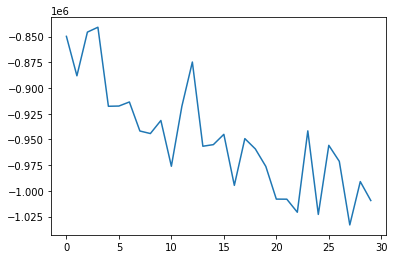

In [35]:
plt.plot(VAE_losses)

In [36]:
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.cuda()
        reconstruction,_,_ = model(test_examples)
        break

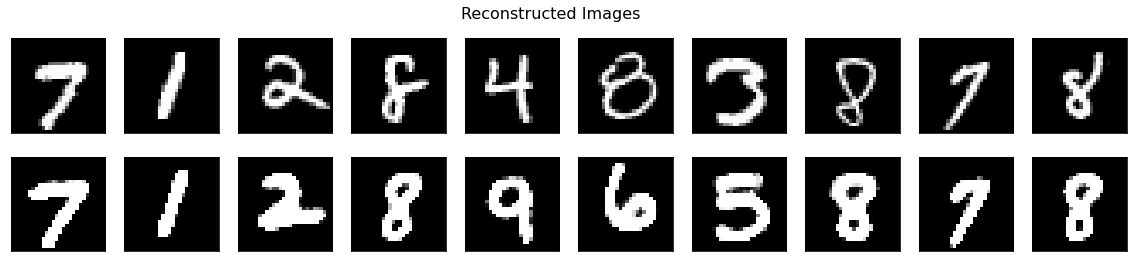

In [37]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    plt.suptitle('Original Images', fontsize=16)
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples.cpu()[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle('Reconstructed Images', fontsize=16)
    for index in range(number):
        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction.cpu()[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

### a) Train a Variational Autoencoder with latent dimension of size 2. Then, plot the digits where their associated position was in latent space similarly as explained in the lecture
code taken from here https://avandekleut.github.io/vae/

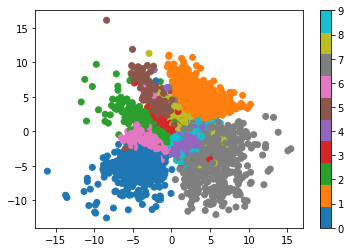

In [38]:
def plot_latent(model, data, num_batches = 100):
  for i, (img, labels) in enumerate(data):
    img = Variable(img).cuda()
    h = model.encoder(img)
    latent_space= model.fc1(h)
    #latent_space, _ = model.encode(img)
    latent_space = latent_space.reshape([64,-1,2])
    latent_space = latent_space.to('cpu').detach().numpy()
    plt.scatter(latent_space[:,:, 0], latent_space[:,:, 1], c=labels.to('cpu').detach().numpy(),  cmap='tab10')
    if i > num_batches:
      plt.colorbar()
      break
plot_latent(model, test_loader)

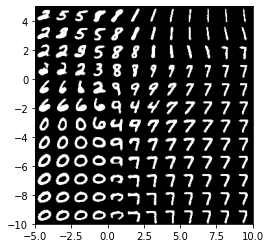

In [39]:
def plot_reconstructed(model, r0=(-5, 10), r1=(-10, 5), n=12):
  w = 28
  img = np.zeros((n*w, n*w))
  for i, y in enumerate(np.linspace(*r1, n)):
      for j, x in enumerate(np.linspace(*r0, n)):
        z = torch.Tensor([[x, y]]).cuda()
        #print(z)
        x_hat = model.decoder(z)
        x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
  plt.imshow(img, extent=[*r0, *r1])
plot_reconstructed(model)